In [7]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install shapely
!pip install pandas
!pip install matplotlib
!pip install seaborn

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ----- ---------------------------------- 0.2/1.4 MB 6.3 MB/s eta 0:00:01
     ------------ --------------------------- 0.4/1.4 MB 5.3 MB/s eta 0:00:01
     --------------------- ------------------ 0.7/1.4 MB 5.9 MB/s eta 0:00:01
     ------------------------------- -------- 1.1/1.4 MB 6.1 MB/s eta 0:00:01
     ---------------------------------------  1.4/1.4 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 5.8 MB/s eta 0:00:00


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path
# Read log files
robomaker_log = 'training-20200831173045-zV8KdB3GRMGEMP5T0NVSyw-robomaker.log'
sagemaker_log = 'training-20200831173044-zV8KdB3GRMGEMP5T0NVSyw-sagemaker.log'

# Verify log files have been read
with open(robomaker_log, 'r') as file:
    print("Robomaker log file read.")

with open(sagemaker_log, 'r') as file:
      print("sagemaker log file read.")

# Read map files
smile_speedway_ccw = 'smile_speedway_ccw.py'
smile_speedway_cw = 'smile_speedway_cw.py'

# Verify map files have been read
with open(smile_speedway_ccw, 'r') as file:
    print("Smile Speedway CCW file read.")

with open(smile_speedway_cw, 'r') as file:
    print("Smile Speedway CW file read.")




Robomaker log file read.
sagemaker log file read.
Smile Speedway CCW file read.
Smile Speedway CW file read.


In [38]:
# define Training Parameters


def robomaker_training_parameters(robomaker_log, training_parameters):
    parameters = {}
    
    with open(robomaker_log, 'r') as file:
        for line in file:
            if line.startswith("PARAMETERS"):
                break
                
        for line in file:
            if line.strip() == "":
                break
                
            try:
                parts = line.strip().split(": ")
                key = parts[0].strip(" *")
                if key in training_parameters:
                    parameters[key] = parts[1]
            except ValueError:
                continue
                
    return parameters
    #Retrieve

training_parameters_to_extract = [
    '/AWS_REGION', 
    '/WORLD_NAME', 
    '/SIMTRACE_S3_PREFIX', 
    '/MODEL_NAME',
    '/RACE_TYPE'
]

json_parameters = robomaker_training_parameters(robomaker_log, training_parameters_to_extract)

print(f"AWS_REGION: {json_parameters.get('/AWS_REGION', ' ')}")
print(f"WORLD_NAME: {json_parameters.get('/WORLD_NAME', ' ')}")
print(f"SIMTRACE_S3_PREFIX: {json_parameters.get('/SIMTRACE_S3_PREFIX', ' ')}")
print(f"MODEL_NAME: {json_parameters.get('/MODEL_NAME', ' ')}")
print(f"RACE_TYPE: {json_parameters.get('/RACE_TYPE', ' ')}")


AWS_REGION: us-east-1
WORLD_NAME: reinvent_base
SIMTRACE_S3_PREFIX: data-f5646ae0-95f...
MODEL_NAME:  
RACE_TYPE: TIME_TRIAL


In [21]:
 #define Hyperparameters

def robomaker_hyperparameters(robomaker_log, hyperparameter_data):
    hyperparameters = {}
    
    with open(robomaker_log, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith("Using the following hyper-parameters"):
            start_index = i + 1
        elif start_index is not None and line.strip() == "}":
            end_index = i
            break

    if start_index is None or end_index is None:
        return hyperparameters
    
    json_block = "".join(lines[start_index:end_index+1]).strip()
    
    try:
        all_hyperparameters = json.loads(json_block)
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
        return hyperparameters
    
    for key in hyperparameter_data:
        hyperparameters[key] = all_hyperparameters.get(key, None)
    
    return hyperparameters

# Retrieve Hyperparameters

#EPI= episodes per iteration
hyperparameters = robomaker_hyperparameters(robomaker_log, ['num_episodes_between_training', 'num_epochs'])
EPI = int(hyperparameters.get('num_episodes_between_training', 0))
NUM_Epochs = int(hyperparameters.get('num_epochs', 0))

print('hyperparameters: %s' % hyperparameters)
print('EPI: %s' % EPI)
print('NUM_Epochs: %s' % NUM_Epochs)


#hyperparameter_data_to_extract = [
  #  "batch_size", 
 #   "num_episodes_between_training", 
  #  "num_epochs"
#]



#json_parameters = robomaker_hyperparameters(robomaker_log, hyperparameter_data_to_extract)
#
#print(f"Batch Size: {json_parameters.get('batch_size', ' ')}")
#print(f"Number of episodes: {json_parameters.get('num_episodes_between_training', ' ')}")
#print(f"Number of epochs: {json_parameters.get('num_epochs', ' ')}")

hyperparameters: {'num_episodes_between_training': 20, 'num_epochs': 10}
EPI: 20
NUM_Epochs: 10


In [22]:



def robomaker_action_space(robomaker_log):
    with open(robomaker_log, 'r') as file:
        for line in file:
            if "Action space from file:" in line:
                action_space_str = line.split("Action space from file:")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'simple'
                
            if "Reward Distribution Graph:  racecar" in line:
                action_space_str = line.split("Reward Distribution Graph:  racecar")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'advanced'
                
    print("Warning: No action space found.")
    return None, None

def display_action_space(action_space_data):
    if action_space_data is None:
        print("No action space data available.")
        return None
    
    # Check for 'index' to distinguish between Advanced and Simple Machines
    if all('index' in action for action in action_space_data):
        action_names = []
        for action in action_space_data:
            action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
            action_speed = ('SPD:%.2f' % action['speed'])
            action_names.append(action_steering + ' / ' + action_speed)
        return action_names
    
    else:  # For Simple Machines
        print("High:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['high']}")
        
        print("\nLow:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['low']}")
        return None


# Retrieve action space
action_space_data, machine_type = robomaker_action_space(robomaker_log)


# Display action space
result = display_action_space(action_space_data)
if result:
    for action in result:
        print(action)



RIGHT:30.0 / SPD:0.33
RIGHT:30.0 / SPD:0.67
RIGHT:30.0 / SPD:1.00
CENTER:0.0 / SPD:0.33
CENTER:0.0 / SPD:0.67
CENTER:0.0 / SPD:1.00
LEFT:30.0 / SPD:0.33
LEFT:30.0 / SPD:0.67
LEFT:30.0 / SPD:1.00


In [23]:
def display_action_space_info(action_space_data, machine_type):
    if machine_type == 'advanced':
        speeds = [entry['speed'] for entry in action_space_data]
        angles = [entry['steering_angle'] for entry in action_space_data]
        
        print("SPEED:", speeds)
        print("STEERING:", angles)
        print("MIN SPEED:", min(speeds))
        print("MAX SPEED:", max(speeds))
        print("MIN STEERING:", min(angles))
        print("MAX STEERING:", max(angles))
        print("SPEED RANGE:", max(speeds) - min(speeds))
        print("STEERING RANGE:", max(angles) - min(angles))
        
    elif machine_type == 'simple':
        speeds = [action_space_data['speed']['high'], action_space_data['speed']['low']]
        angles = [action_space_data['steering_angle']['high'], action_space_data['steering_angle']['low']]
        
        print("SPEED:", speeds)
        print("STEERING:", angles)

# Usage example
action_space_data, machine_type = robomaker_action_space(robomaker_log)
if action_space_data and machine_type:
    display_action_space_info(action_space_data, machine_type)
else:
    print("Failed to load action space data.")


SPEED: [0.3333333333333333, 0.6666666666666666, 1, 0.3333333333333333, 0.6666666666666666, 1, 0.3333333333333333, 0.6666666666666666, 1]
STEERING: [-30, -30, -30, 0, 0, 0, 30, 30, 30]
MIN SPEED: 0.3333333333333333
MAX SPEED: 1
MIN STEERING: -30
MAX STEERING: 30
SPEED RANGE: 0.6666666666666667
STEERING RANGE: 60


In [24]:
# Initialize list to store SIM_TRACE_LOG lines
sim_trace_logs = []

# Read the log file line by line
with open(robomaker_log, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            p = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_trace_logs.append(",".join(p))
            #sim_trace_logs.append(line.strip())  # Add line to the list after stripping newline characters

# Now you have the SIM_TRACE_LOG lines in the list `sim_trace_logs`
if sim_trace_logs:
    print("SIM_TRACE_LOG loded")
else:
    print(" SIM_TRACE_LOG data not found.")


SIM_TRACE_LOG loded


In [37]:
import pandas as pd

#raw sim table
# Reading the log file

df_list = list()

for t in sim_trace_logs[2:]:
    p = t.rstrip().split(",")
    episode = int(p[0])
    steps = int(p[1])
    x = 100*float(p[2])
    y = 100*float(p[3])
    yaw = float(p[4])
    steer = float(p[5])
    speed = float(p[6])
    action = float(p[7])
    reward = float(p[8])
    done = 0 if 'False' in p[9] else 1
    progress = float(p[11])
    length = float(p[13])
    timestamp = float(p[14])
    stat = p[15]
    











    iteration = int(episode / EPI) + 1
    if (iteration ==1) and (episode ==0):
        steps -= 2
    episode_in_iteration = (episode % EPI) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, speed, action, reward, done, progress, length, timestamp,  stat))
header = ['iteration', 'EPI(now working)', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'speed', 'action', 'reward', 'done', 'progress', 'length', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df
    





,iteration,EPI(now working),episode,steps,x,y,yaw,steer,speed,action,reward,done,progress,length,timestamp,status
0,1,1,1,1,305.28,68.89,1.1585,0.0,1.00,5.0,1.000,0,0.8083,17.67,1.598891e+09,in_progress
1,1,1,1,2,305.98,69.60,2.8803,0.0,0.33,3.0,1.000,0,0.8478,17.67,1.598891e+09,in_progress
2,1,1,1,3,306.68,69.80,3.2681,30.0,0.33,6.0,1.000,0,0.8872,17.67,1.598891e+09,in_progress
3,1,1,1,4,307.19,69.15,1.5659,30.0,0.67,7.0,1.000,0,0.9160,17.67,1.598891e+09,in_progress
4,1,1,1,5,308.63,67.51,-2.5738,0.0,0.67,4.0,1.000,0,0.9979,17.67,1.598891e+09,in_progress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,8,20,160,358,58.89,214.74,-91.7308,0.0,0.33,3.0,0.001,0,88.1903,17.67,1.598895e+09,in_progress
26276,8,20,160,359,58.64,211.18,-92.0737,-30.0,1.00,2.0,0.001,0,88.3850,17.67,1.598895e+09,in_progress
26277,8,20,160,360,57.93,207.33,-93.4554,30.0,0.33,6.0,0.001,0,88.5902,17.67,1.598895e+09,in_progress
26278,8,20,160,361,57.12,203.18,-94.7508,30.0,1.00,8.0,0.001,0,88.8108,17.67,1.598895e+09,in_progress


In [40]:
#episode data

episode_sim_df = sim_df[sim_df["done"] == 1][["iteration", "EPI(now working)", "episode", "steps", "progress", "status"]].copy()
episode_sim_df["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
episode_sim_df["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")



episode_sim_df


,iteration,EPI(now working),episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
101,1,1,1,102,21.9369,off_track,57.009,6.754110,1.598891e+09,1.598891e+09
243,1,2,2,142,39.5705,off_track,78.209,9.431465,1.598891e+09,1.598891e+09
325,1,3,3,82,19.2111,off_track,38.710,5.417299,1.598891e+09,1.598891e+09
381,1,4,4,56,13.8055,off_track,24.910,3.684319,1.598891e+09,1.598892e+09
406,1,5,5,25,4.9366,off_track,10.508,1.586663,1.598892e+09,1.598892e+09
...,...,...,...,...,...,...,...,...,...,...
25287,8,16,156,333,78.7686,off_track,241.506,22.187699,1.598895e+09,1.598895e+09
25537,8,17,157,250,62.8533,off_track,141.309,16.643970,1.598895e+09,1.598895e+09
25889,8,18,158,352,90.9612,off_track,269.007,23.485157,1.598895e+09,1.598895e+09
25917,8,19,159,28,6.8090,off_track,9.512,1.801389,1.598895e+09,1.598895e+09


In [41]:
#iteration-related data

#NOT WORKING corectly 

iteration_sim_df = episode_sim_df[episode_sim_df["EPI(now working)"] == 1][["iteration"]].copy()
iteration_sim_df["min_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("min")
iteration_sim_df["max_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("max")
iteration_sim_df["avg_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("mean")
iteration_sim_df["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
iteration_sim_df["start_time"] = episode_sim_df.groupby("iteration")["start_time"].transform("min")
iteration_sim_df["end_time"] = episode_sim_df.groupby("iteration")["end_time"].transform("max")

iteration_sim_df


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time
101,1,2.7347,92.5977,30.238570,1319.954,1.598891e+09,1.598892e+09
2532,2,6.8166,81.4535,32.172795,1491.748,1.598892e+09,1.598892e+09
5095,3,5.5750,98.0393,26.394590,1225.616,1.598892e+09,1.598892e+09
7398,4,3.8055,100.0000,38.660530,2039.683,1.598893e+09,1.598893e+09
10337,5,4.6550,100.0000,47.265715,2508.863,1.598893e+09,1.598893e+09
14332,6,5.4057,100.0000,42.627855,2219.914,1.598893e+09,1.598894e+09
17836,7,2.6305,100.0000,50.937350,2772.280,1.598894e+09,1.598894e+09
22021,8,6.2585,100.0000,52.557025,2887.868,1.598894e+09,1.598895e+09


In [42]:
!pip install scikit-learn

In [43]:
from sklearn.preprocessing import MinMaxScaler

x = iteration_sim_df[['total_rewards']].values.astype(float)
if len(x) > 0:  # Missing parenthesis fixed
    min_max_scaler = MinMaxScaler(feature_range=(5, 95))
    x_scaled = min_max_scaler.fit_transform(x)
    iteration_sim_df['normalized_total_rewards'] = x_scaled

print('%d' % len(iteration_sim_df))

if len(iteration_sim_df) > 0:
    iteration_sim_df['normalized_total_rewards_SMA3'] = iteration_sim_df['normalized_total_rewards'].rolling(window=3).mean()
    iteration_sim_df['min_progress_SMA3'] = iteration_sim_df['min_progress'].rolling(window=3).mean()
    iteration_sim_df['max_progress_SMA3'] = iteration_sim_df['max_progress'].rolling(window=3).mean()
    iteration_sim_df['avg_progress_SMA3'] = iteration_sim_df['avg_progress'].rolling(window=3).mean()
    #iteration_sim_df['pct_completed_laps_SMA3'] = iteration_sim_df['pct_completed_laps'].rolling(window=3).mean()

iteration_sim_df


8


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time,normalized_total_rewards,normalized_total_rewards_SMA3,min_progress_SMA3,max_progress_SMA3,avg_progress_SMA3
101,1,2.7347,92.5977,30.238570,1319.954,1.598891e+09,1.598892e+09,10.107781,NaN,NaN,NaN,NaN
2532,2,6.8166,81.4535,32.172795,1491.748,1.598892e+09,1.598892e+09,19.409295,NaN,NaN,NaN,NaN
5095,3,5.5750,98.0393,26.394590,1225.616,1.598892e+09,1.598892e+09,5.000000,11.505692,5.042100,90.696833,29.601985
7398,4,3.8055,100.0000,38.660530,2039.683,1.598893e+09,1.598893e+09,49.076367,24.495221,5.399033,93.164267,32.409305
10337,5,4.6550,100.0000,47.265715,2508.863,1.598893e+09,1.598893e+09,74.479375,42.851914,4.678500,99.346433,37.440278
14332,6,5.4057,100.0000,42.627855,2219.914,1.598893e+09,1.598894e+09,58.834689,60.796811,4.622067,100.000000,42.851367
17836,7,2.6305,100.0000,50.937350,2772.280,1.598894e+09,1.598894e+09,88.741671,74.018578,4.230400,100.000000,46.943640
22021,8,6.2585,100.0000,52.557025,2887.868,1.598894e+09,1.598895e+09,95.000000,80.858787,4.764900,100.000000,48.707410


In [31]:
#Amazon SageMaker) Logs
#check that SageMaker log exist

with open(sagemaker_log, 'r') as file:
      print("sagemaker log file read.")

sagemaker log file read.


In [32]:
import re

policytrn_data = []
last_iteration = 0

with open(sagemaker_log, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            match = re.search(r"Training iteration=(\d+)", line)
            if match:
                last_iteration = match.group(1)
        
        if "Policy training> " in line:
            parts = re.findall(r"([-\d.e]+)", line)
            parts = [p for p in parts if p != 'e']
            policytrn_data.append(",".join([last_iteration] + parts))

print(policytrn_data[1:20])


['0,-0.07294478267431259,0.02815358340740204,1.8107534646987915,1,0.0003', '0,-0.1045914888381958,0.03385936841368675,1.8013898134231567,2,0.0003', '0,-0.12287378311157227,0.03728732466697693,1.8033291101455688,3,0.0003', '0,-0.13031166791915894,0.04420778900384903,1.7868491411209106,4,0.0003', '0,-0.135797917842865,0.052170529961586,1.7815730571746826,5,0.0003', '0,-0.14248019456863403,0.05765051022171974,1.7744756937026978,6,0.0003', '0,-0.14707088470458984,0.06195580214262009,1.7635325193405151,7,0.0003', '0,-0.14903908967971802,0.0680307075381279,1.753975749015808,8,0.0003', '0,-0.15176823735237122,0.0695502981543541,1.7581148147583008,9,0.0003', '1,0.029724041000008583,0.03584299981594086,1.8238815069198608,0,0.0003', '1,-0.07250187546014786,0.053284455090761185,1.7924264669418335,1,0.0003', '1,-0.10452742874622345,0.061382513493299484,1.782528281211853,2,0.0003', '1,-0.1251341849565506,0.06327565014362335,1.7632099390029907,3,0.0003', '1,-0.1366412341594696,0.07028432190418243,1.

In [33]:
#Parse policy training data

df_list = list()

for d in policytrn_data:
    p = d.rstrip().split(",")
    iteration = int(p[0]) + 1
    #surrogate_loss = float(p[1])
    #kl_divergence = float(p[12)
    entropy = float(p[3])
    training_epoch = float(p[4])
    learning_rate = float(p[5])
    #avg_entropy = policytrn_df.groupby("iteration")["entropy"].transform("mean")

    df_list.append((iteration, entropy, training_epoch, learning_rate))


header = ['iteration', 'entropy', 'training_epoch', 'learning_rate']

policytrn_df = pd.DataFrame(df_list, columns=header)
policytrn_df
    
    
    

,iteration,entropy,training_epoch,learning_rate
0,1,1.832128,0.0,0.0003
1,1,1.810753,1.0,0.0003
2,1,1.801390,2.0,0.0003
3,1,1.803329,3.0,0.0003
4,1,1.786849,4.0,0.0003
...,...,...,...,...
72,8,1.569908,2.0,0.0003
73,8,1.557475,3.0,0.0003
74,8,1.534363,4.0,0.0003
75,8,1.529621,5.0,0.0003


In [34]:
#aggregated values for iterations

if(len(policytrn_df)>0):
    policytrn_df["avg_entropy"] = policytrn_df.groupby("iteration")["entropy"].transform("mean")
    policytrn_df_entropy = policytrn_df[policytrn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

policytrn_df_entropy['SMA3_avg_entropy'] = policytrn_df_entropy.iloc[:,1].rolling(window=3).mean()
policytrn_df_entropy
    
    

,iteration,avg_entropy,SMA3_avg_entropy
1,1,1.786612,NaN
11,2,1.763531,NaN
21,3,1.756189,1.768777
31,4,1.684107,1.734609
41,5,1.662307,1.700868
51,6,1.609808,1.652074
61,7,1.572735,1.614950
71,8,1.561176,1.581240


Number of episodes =  160
Number of complete iterations =  8


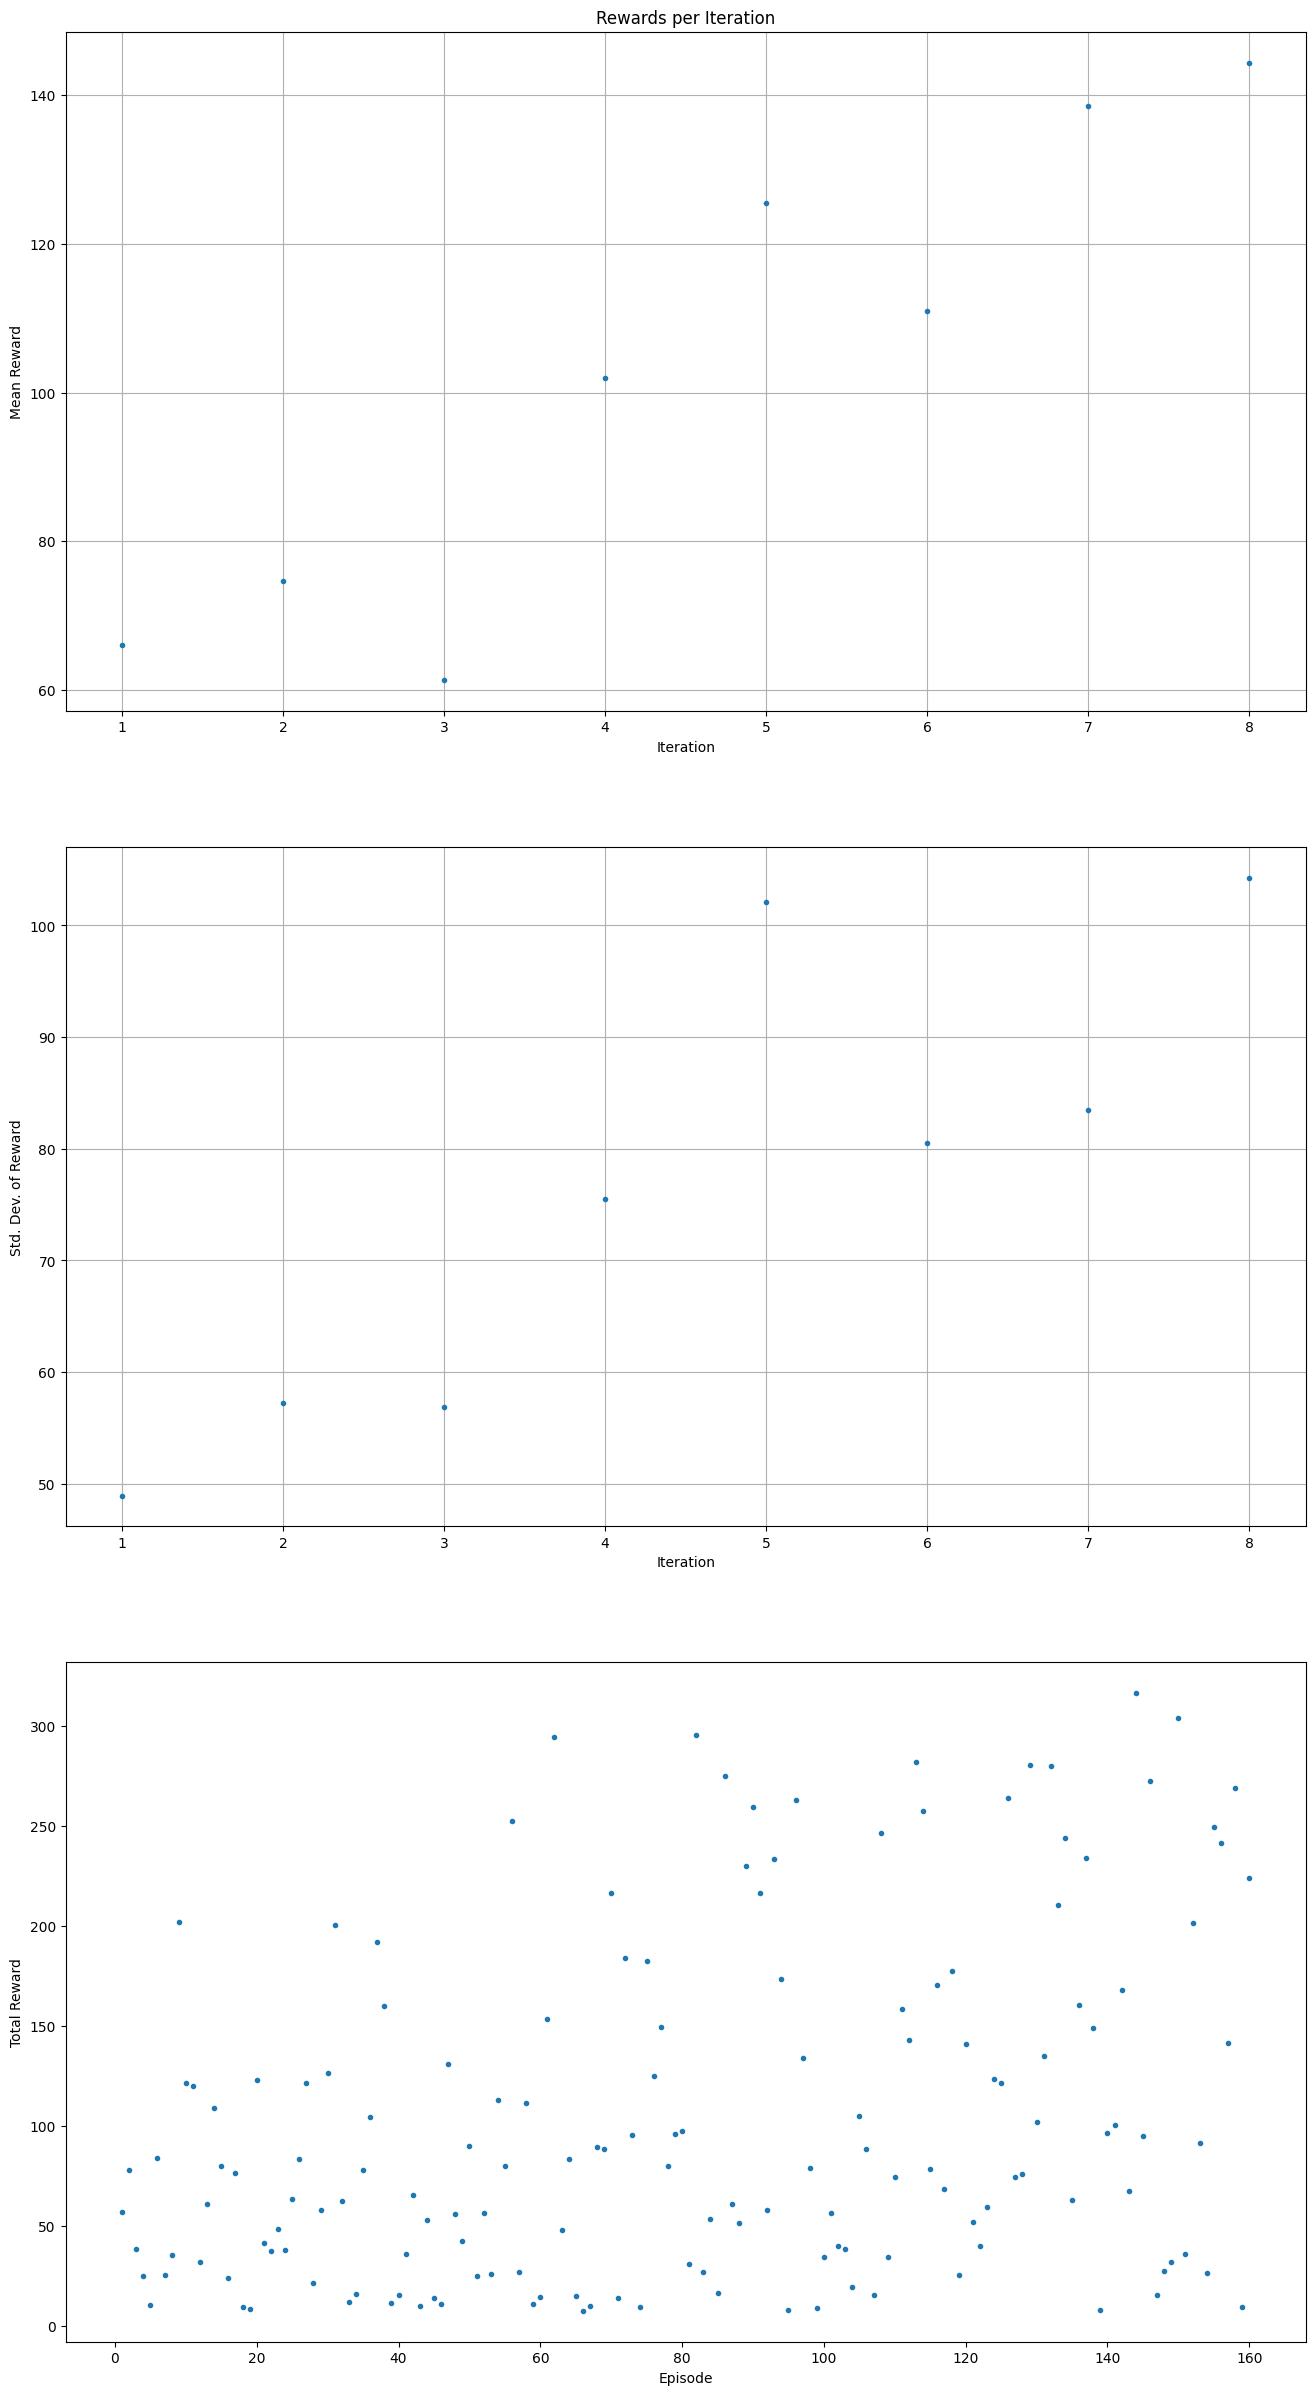

In [35]:
#Reward graph per episode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

max_ep = np.max(sim_df['episode'])
max_iteration = np.max(policytrn_df['iteration']) #tempoary fix 
print('Number of episodes = ', max_ep)
print('Number of complete iterations = ', max_iteration)


# Calculate total rewards per episode
total_rewards = sim_df.groupby('episode')['reward'].sum().values

# Calculate average and standard deviation of rewards per iteration
buffer_rew = []
average_rewards, deviation_rewards = [], []

for idx, reward in enumerate(total_rewards, 1):
    buffer_rew.append(reward)
    if idx % EPI == 0:
        average_rewards.append(np.mean(buffer_rew))
        deviation_rewards.append(np.std(buffer_rew))
        buffer_rew.clear()

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(16, 30))

# Plot average rewards
axes[0].plot(range(1, len(average_rewards) + 1), average_rewards, '.')
axes[0].set(title='Rewards per Iteration', xlabel='Iteration', ylabel='Mean Reward')
axes[0].grid(True)

# Plot standard deviation of rewards
axes[1].plot(range(1, len(deviation_rewards) + 1), deviation_rewards, '.')
axes[1].set(ylabel='Std. Dev. of Reward', xlabel='Iteration')
axes[1].grid(True)

# Plot total rewards
axes[2].plot(range(1, len(total_rewards) + 1), total_rewards, '.')
axes[2].set(ylabel='Total Reward', xlabel='Episode')
axes[2].grid(False)

plt.show()


In [19]:
#Performance Envelope of the Model graph-to do

In [35]:
#Potential Model Checkpoints for Cloning and Race Submission-to do

KeyError: 'total_rewards_SMA3'

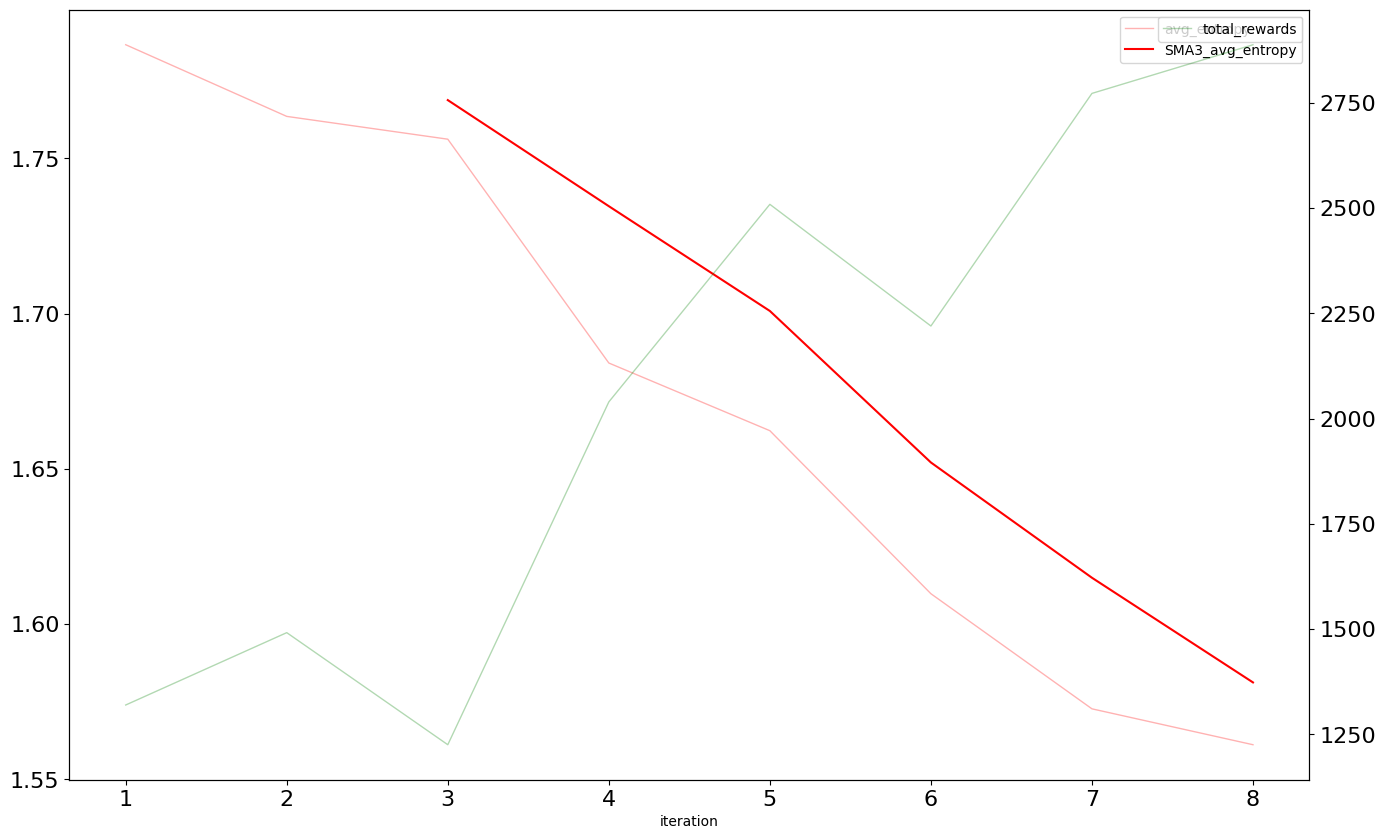

In [36]:
#def reward_graph(df_RELP_iterations=iteration_sim_df, df_RELP_entropy=policytrn_df_entropy)
    #font_size=21


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_line(ax, df, x_col, y_col, **kwargs):
    df.plot(kind='line', x=x_col, y=y_col, ax=ax, **kwargs)

def plot_max_point(ax, df, x_col, y_col, label, font_size):
    max_iter = df[y_col].idxmax()
    if max_iter >= 0:
        x_val, y_val = df.loc[max_iter, [x_col, y_col]]
        ax.axvline(x=x_val, linestyle='dotted', linewidth=0.75, color='black')
        ax.axhline(y=y_val, linestyle='dotted', linewidth=0.75, color='black', alpha=0.3)
        ax.text(x_val * 0.995, y_val * 1.005, f'{label} @ {x_val}', ha='right', va='bottom', size=font_size)

def plot_reward_graph(df_RELP_iterations, df_RELP_entropy):
    if df_RELP_iterations.empty:
        return
    
    font_size = 16
    fig, ax1 = plt.subplots(figsize=(16, 10))
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twinx()
    
    # Plot Entropy
    plot_line(ax1, df_RELP_entropy, 'iteration', 'avg_entropy', linewidth=1, color='red', alpha=0.3, fontsize=font_size)
    plot_line(ax1, df_RELP_entropy, 'iteration', 'SMA3_avg_entropy', linewidth=1.5, color='red', fontsize=font_size)
    
    # Plot Rewards and Progress
    for col, style, color in [('total_rewards', 'solid', 'green'), ('avg_progress', 'dashdot', 'blue')]:
        plot_line(ax2, df_RELP_iterations, 'iteration', col, linewidth=1, color=color, alpha=0.3, fontsize=font_size)
        plot_line(ax2, df_RELP_iterations, 'iteration', f'{col}_SMA3', linestyle=style, linewidth=1.5, color=color, fontsize=font_size)
        
    # Add text and lines for max points
    plot_max_point(ax2, df_RELP_iterations, 'iteration', 'normalized_total_rewards_SMA3', 'Max Rewards', font_size)
    plot_max_point(ax2, df_RELP_iterations, 'iteration', 'avg_progress_SMA3', 'Max Progress', font_size)
    
    ax1.set_xlabel('Iteration', fontsize=font_size)
    ax1.set_ylabel('Entropy', fontsize=font_size)
    ax2.set_ylabel('Normalized Rewards / Progress (%)', fontsize=font_size)

    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

# Call the function
plot_reward_graph(iteration_sim_df, policytrn_df_entropy)